# Thinking Probabilistically (mod1-part1)

## Coin Flipping Problem

$\theta$ is the *bias* in the coin flipping problem: if it is a fair coin you'd get 0.5; you want to infer the actual bias from observations.

You toss the coin N times.
Let's define with $y$ the number of occurrences of heads, and $\theta$ be the (true) probability of getting a head from the coin.

The following is a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution):

$$
p(y|\theta,N) = \frac{N!}{y!(N-y)!}\theta^{y}(1-\theta)^{N-y}
$$

We will use [scipy.stats.binom](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html) for the binomial distribution.

<br/><br/>

**Other references**

pmf: [probability mass function](https://en.wikipedia.org/wiki/Probability_mass_function)


## Binomial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import arviz as az


In [2]:
az.style.use('arviz-darkgrid') #beautify plots with dark grid background and font size

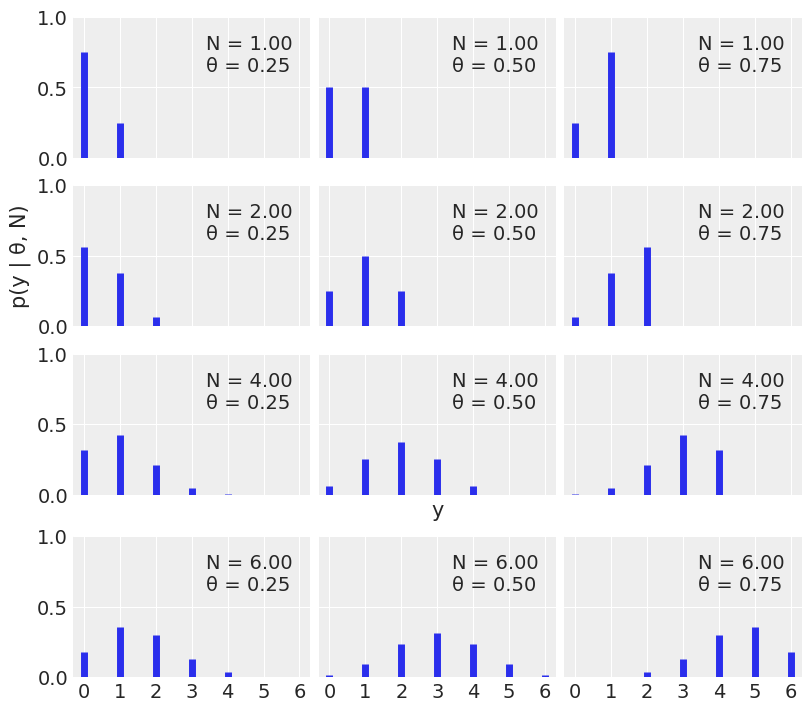

In [4]:
n_params = [1, 2, 4, 6]  # Number of trials
p_params = [0.25, 0.5, 0.75]  # Probability of success (e.g., getting head)

x = np.arange(0, max(n_params)+1)



_,ax = plt.subplots(len(n_params), len(p_params), sharex=True, sharey=True,
                    figsize=(8, 7), constrained_layout=True)

for i in range(len(n_params)):
    for j in range(len(p_params)):
        n = n_params[i]
        p = p_params[j]

        y = stats.binom(n=n, p=p).pmf(x)
        #y = stats.binom.pmf(x,n=n,p=p) # can be also written

        ax[i,j].vlines(x, 0, y, colors='C0', lw=5)
        ax[i,j].set_ylim(0, 1)
        ax[i,j].plot(0, 0, label="N = {:3.2f}\nθ = {:3.2f}".format(n,p), alpha=0)
        ax[i,j].legend()


ax[2,1].set_xlabel('y')
ax[1,0].set_ylabel('p(y | θ, N)')
ax[0,0].set_xticks(x)


#plt.savefig('./output/B11197_01_03.png', dpi=400)



<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Note</b><br>
    <p style="color: black">
        Notice that for discrete distributions, the sum of the heights correspond to actual probabilities.
    </p>
</div>

<code> A Binomial distribution for this problem is a reasonable choice for the likelihood. If we know the value of θ, we can calculate the expected distribution of heads.
</code>

<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Note</b><br>
    <p style="color: black">
        The problem is that you may not know the true value of θ (for example, if the coin is not fair)! But here comes the Bayesian reasoning approach: any time you do not know the value of a parameter, we put a prior on it.
    </p>
</div>


<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-question-circle" aria-hidden="true"></i>&nbsp; Question</b><br>
    <p style="color: black">
        What happens to a posterior if your prior is a Dirac delta distribution? (notice the space of $\theta$ is continuous.)
    </p>
</div>

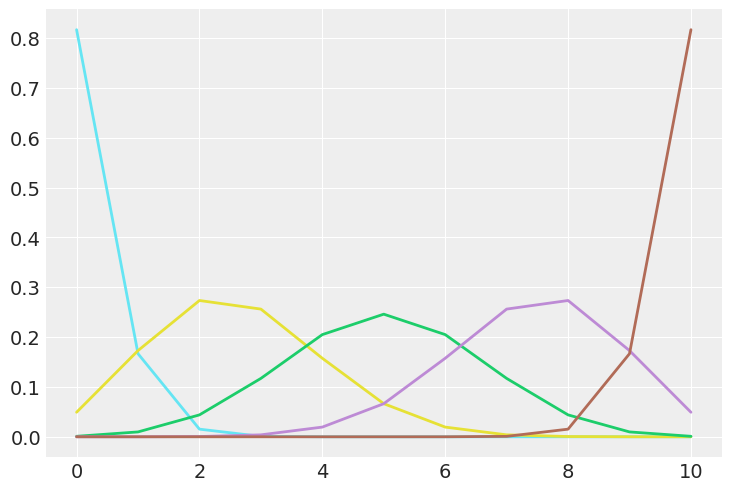

In [5]:
n=10
p=np.linspace(0.02,0.98,5)

plt.figure()
for i,valp in enumerate(p):

    tstr = 'C'+str(i+5)
    x=np.arange(0,n+1)
    y=stats.binom.pmf(x, n, valp)

    #fig, ax = plt.subplots()

    plt.plot(x, y, linewidth=2.0,color=tstr)

## Choosing the Prior

Text(-0.07, 0.5, 'p(θ)')

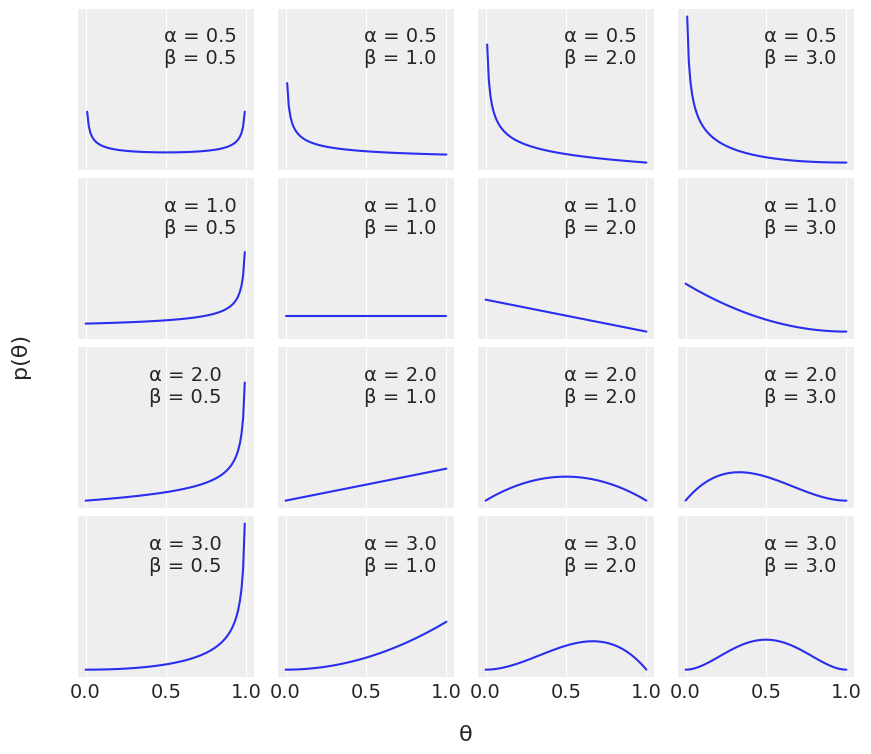

In [7]:
params = [0.5, 1, 2, 3]
x = np.linspace(0, 1, 100)
f, ax = plt.subplots(len(params), len(params), sharex=True, sharey=True,
                     figsize=(8, 7), constrained_layout=True)
for i in range(4):
    for j in range(4):
        a = params[i]
        b = params[j]
        y = stats.beta(a, b).pdf(x)
        ax[i,j].plot(x, y)
        ax[i,j].plot(0, 0, label="α = {:2.1f}\nβ = {:2.1f}".format(a, b), alpha=0)
        ax[i,j].legend()
ax[1,0].set_yticks([])
ax[3,0].set_xticks([0, 0.5, 1])
f.text(0.5, -0.05, 'θ', ha='center', size=16)
f.text(-0.07, 0.5, 'p(θ)', va='center', rotation=90, size=16)
#plt.savefig('./output/B11197_01_04.png', dpi=400)

<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Note</b><br>
    <p style="color: black">
        The beta distribution is continuous.
     </p>
     <p style="color: blue">
        In Bayesian probability theory, if the posterior distribution
        p(θ | x) is in the same probability distribution family as the
        prior probability distribution p(θ), the prior and posterior are
        then called conjugate distributions, and the prior is called a
        conjugate prior for the likelihood function p(x | θ).
    </p>
</div>

[https://en.wikipedia.org/wiki/Conjugate_prior](https://en.wikipedia.org/wiki/Conjugate_prior)

## Computing and plotting the posterior

Now, you must know that the beta distribution looks as follows

$p(\theta) = \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}\theta^{\alpha-1}(1-\theta)^{\beta-1}$ (1)


Where $\Gamma$ is the [gamma function](https://en.wikipedia.org/wiki/Gamma_function).
If the maths starts sounding complicated, do not worry. I want you to pay attention to some approximation we can do to calculate the posterior starting from our $\beta$ prior and our Binomial-likelihood.
Later, we will do this calculation more accurately with PyMC, but for now, let's notice the following:

- (1), the $\beta$-distribution, looks like a Binomial, with the exception of some factors


From the Bayes'theorem, we know that the posterior is proportional to the likelihood times the prior. Let's now do the following approximation (remember, $y$ are the observations):

$p(\theta|y) \propto \frac{N!}{y!(N-y)!}\theta^{y}(1-\theta)^{N-y} \cdot
\frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}\theta^{\alpha-1}(1-\theta)^{\beta-1}$

Let's drop all the terms that do not depend on $\theta$, to get:

$p(\theta|y) \propto \theta^{y}(1-\theta)^{N-y} \theta^{\alpha-1}(1-\theta)^{\beta-1}$

that is:

$p(\theta|y) \propto \theta^{y+\alpha-1}(1-\theta)^{N-y+\beta-1}$

In other words, the posterior is proportional to a beta-function

$p(\theta|y) \propto Beta(\alpha_{prior}+y,\beta_{prior}+N-y)$




### Using the above equation:


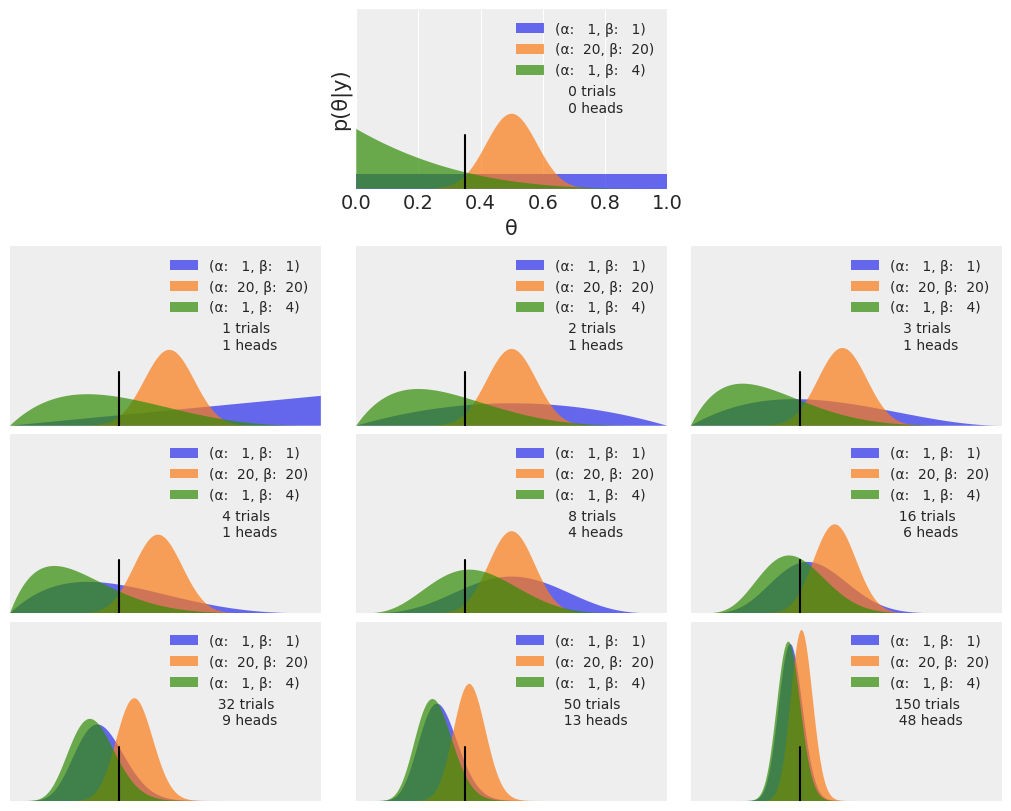

In [9]:
plt.figure(figsize=(10, 8))

n_trials = [0, 1, 2, 3, 4, 8, 16, 32, 50, 150]
data     = [0, 1, 1, 1, 1, 4,  6,  9, 13,  48]
theta_real = 0.35

#------ replace with actual generation from binomial with theta_real ------#
rep_data = []
for nn in n_trials:
    rep_data.append(stats.binom.rvs(nn, theta_real))  #rvs: random variates
#--------------------------------------------------------------------------#

#data = rep_data

beta_params = [(1, 1), (20, 20), (1, 4)]

dist = stats.beta
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html

x = np.linspace(0, 1, 200)

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for idx, N in enumerate(n_trials):
    if idx == 0:
        plt.subplot(4, 3, 2) #take idx=2 plot
        plt.xlabel('θ')
        plt.ylabel('p(θ|y)')
    else:
        plt.subplot(4, 3, idx+3)
        plt.xticks([])
    y = data[idx]
    for idx2, (a_prior, b_prior) in enumerate(beta_params):
        #tmp_color = colors[idx2]
        p_theta_given_y = dist.pdf(x, a_prior + y, b_prior + N - y)
        plt.fill_between(x, 0, p_theta_given_y,alpha=0.7,
                         label=f'(α: {a_prior:3d}, β: {b_prior:3d})')


    plt.axvline(theta_real, ymax=0.3, color='k')
    plt.plot(0, 0, label=f'{N:4d} trials\n{y:4d} heads', alpha=0)
    plt.xlim(0, 1)
    plt.ylim(0, 12)
    plt.legend(fontsize=10)
    plt.yticks([])



#plt.tight_layout() #check compatibility
#plt.savefig('./output/B11197_01_05.png', dpi=300)


<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Note</b><br>
    <p style="color: black">
      -  PMF uses discrete random variables. PDF uses continuous random variables.  
    </p>
    <p style="color: black">
      -  In the first row we have 0 trials, therefore the three curves are our priors for different settings of the beta-distribution parameters
    </p>
    <p style="color: black">
    - The most probable value is given by th emode of the posterior
    </p>
    <p style="color: black">
    - The spread of the posterior is proportional to the uncertainty about the value of a parameter
    </p>  
    <p style="color: red">
    - Given a sufficiently large amount of data, Bayesian models with different priors converge to the same result!
    </p>    
    <p style="color: black">
    - How fast posteriors converge depend on the data and the model
    </p>  
    <p style="color: black">
    - It can be demonstrated that the same result is obtained by updating the posterior sequentially than if we do it all at once
    </p>   
</div>


<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Note</b><br>   
    <p style="color: black">
      -  Priors can influence inference... some peoplelike the idea of flat, weakly informative priors
     </p>  
    <p style="color: black">
      - we have seen though prior information can be essential in some cases, e.g., if the parameter has to be positive
    </p>
    <p style="color: black">
      - Priors can make our models work better.
    </p>      
    <p style="color: black">
      - Frequentist approach estimates parameters through maximum likelihood, avoiding setting up a prior, and works by findining the value of θ that maximizes the likelihood. We have seen in our exercises the limitations of this approach.
    </p>   
</div>  